## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Mudelid
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Mutual info
from sklearn.feature_selection import mutual_info_classif

# SMOTE
from imblearn.over_sampling import SMOTE

## Insert the .csv dataset path here

In [2]:
file = "synthetic_data_lung_cancer.csv"

## Raw data processing

In [3]:
def load_data(file, drop_values=None):
    
    # Data
    data = pd.read_csv(file)
    pd.set_option('display.max_rows', 20)
    surnud= data[data["DEFINITION_ID"] == "death"]
    subject_ids = surnud["SUBJECT_ID"]
    
    # Filtreerib surnute id põhjal
    surnud = data[data["SUBJECT_ID"].isin(subject_ids)]
    
    # Muudame aja väärtuse 1-ks, ehk esialgsetes andmetes "DEFINITION_ID" = TIME, nüüd selle asemel lihtsalt 1.
    surnud["TIME"] = 1
    elus = data[data["DEFINITION_ID"] != "death"]
    elus["TIME"] = 1

    # Sama toimub ka siin, aga elus patsientidega
    elus_filtered = elus[~elus["SUBJECT_ID"].isin(surnud["SUBJECT_ID"])]

    # Filtreeritud andmete kombineerimine üheks tabeliks
    combined_data = pd.concat([surnud, elus_filtered])
    combined_data.sort_values(by='SUBJECT_ID', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)
    
    # Tagastatav tabel - read on patsiendid, veerud on protseduurid
    # 1 = protseduur tehti, 0 = patsient pole protseduuri saanud
    # Samuti ka veerg "death": 1 = surnud, 0 = "elus"
    
    pivot_combined_data = combined_data.pivot_table(index='SUBJECT_ID', columns='DEFINITION_ID', values='TIME', aggfunc='sum', fill_value=0)
    if drop_values:
        for value in drop_values:
            if value:
                cols_to_drop = pivot_combined_data.filter(like=value).columns
                pivot_combined_data = pivot_combined_data.drop(columns=cols_to_drop)
    return pivot_combined_data

## Feature selection/processing (PCA)

In [4]:
def identify_important_features(X, save_loadings=False):
    n_components=20
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # DataFrame with the principal components
    pc_columns = [f'PC_{i+1}' for i in range(n_components)]
    
    # Variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_ 
    
    all_pca_loadings = [loadings for loadings in pca.components_]
    
    if save_loadings:
        loadings_dfs = []
        for index, loadings in enumerate(all_pca_loadings):
            loadings_df = pd.DataFrame({'Feature': X.columns, f'Loading_PC{index+1}': loadings})
            loadings_df[f'Absolute_Loading_PC{index+1}'] = loadings_df[f'Loading_PC{index+1}'].abs()
            loadings_df = loadings_df.sort_values(by=f'Absolute_Loading_PC{index+1}', ascending=False)
            loadings_dfs.append(loadings_df)
        
        combined_loadings_df = pd.concat(loadings_dfs, axis=1)
        combined_loadings_df.to_csv('combined_loadings.csv', index=False, encoding="utf-8")
    
    loadings_pc = pca.components_[0]
    
    loading_df = pd.DataFrame({'Feature': X.columns, 'Loading_PC1': loadings_pc})
    loading_df['Absolute_Loading_PC1'] = loading_df['Loading_PC1'].abs()
    loading_df = loading_df.sort_values(by='Absolute_Loading_PC1', ascending=False)
    
    return pd.DataFrame(X_pca, columns=pc_columns), explained_variance_ratio, pca, loading_df

## Model training, based on the parameters from Grid Search

In [5]:
def train_model(X, y, model_type):
    svm_params = {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 100}
    knn_params = {'weights': 'distance', 'p': 2, 'n_neighbors': 16, 'algorithm': 'auto'}
    rf_params = {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
    gradient_params = {'learning_rate': 0.2, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
    if model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42,**rf_params)
    elif model_type == 'SVM':
        model = SVC(probability=True, random_state=42,**svm_params)
    elif model_type == 'KNeighbors':
        model = KNeighborsClassifier(**knn_params)
    elif model_type == "Gradient":
        model = GradientBoostingClassifier(random_state=42,**gradient_params)
    
    else:
        raise ValueError(f'Invalid model type: {model_type}')
    
    model.fit(X, y)
    return model

## Evaluation of the model

In [6]:
def evaluate_model(model, X, y):
    y_probabilities = model.predict_proba(X)[:, 1]    
    auc_roc = roc_auc_score(y, y_probabilities)
    
    return auc_roc

## Running the workflow

In [7]:
def main(file):
    
    # PCde loomisel väljajäetavate interventionite kombinatsioonid
    drop_value_combinations = [
        
        # PCde loomine kõikide interventionitega
        [], 
        
        # Individuaalsete interventionite väljajätmine, et näha nende mõju AUC-ROC skoorile
        ["condition_"], 
        ["drug_"], 
        ["observation_"], 
        ["procedure_"], 
        ["measurement"],
        
        # Kombinatsioon, millega saavutasime parima AUC-ROC skoori
        ["drug_", "condition_", "procedure_"]
    ]
    
    results = {}
    for value_combination in drop_value_combinations:
        data = load_data(file, drop_values=value_combination)
        X = data.drop(columns=['death'])
        y = data['death']

        # Salvestame ainult parima kombinatsiooniga PCde loadingud
        save_loadings = True if value_combination == ["drug_", "condition_", "procedure_"] else False
        
        # "save_loadings=True" - tekib .csv fail, kust saab hiljem tunnuste osakaalu PC-de moodustamisel vaadata
        important_features, explained_variance_ratio, pca, loading_df = identify_important_features(X, save_loadings=save_loadings)
        model_types = ['RandomForest','SVM', 'KNeighbors','Gradient']

        # Mudelite treenimine (x = important_features ehk mudelid treenitakse genereeritud PCde põhjal)
        X_train, X_test, y_train, y_test = train_test_split(important_features, y, test_size=0.2, random_state=42)
        
        #Lisasime juurde tavalise rf mudeli, mis ei rakenda PCA-d, et printida rf poolt tagastatud olulisi tunnuseid
        fx_train, fx_test, fy_train, fy_test = train_test_split(X, y, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(fx_train, fy_train)
        importances = clf.feature_importances_
        feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        print(feature_importances[:50].to_string())
        y_probabilities = clf.predict_proba(fx_test)[:, 1]
        print(roc_auc_score(fy_test, y_probabilities))

        for model_type in model_types:
            model = train_model(X_train, y_train, model_type=model_type)
            auc_roc = evaluate_model(model, X_test, y_test)
            results[f"{model_type} without {value_combination}"] = auc_roc

    return results

# KASUTAMINE! - File = jooksutav csv fail!
#file = "synthetic_data_lung_cancer.csv"

# Run the main script
results = main(file)

counter = 0

print("\nAUC-ROC Scores:")
for model_type, auc_roc in results.items():
    print(f'{model_type}: {auc_roc}')
    counter += 1
    if counter == 4:
        print()
        counter = 0

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               feature  importance
3554   measurement_463    0.005317
3844   measurement_724    0.003447
2989  measurement_1153    0.003115
4175   observation_122    0.002828
4038     measurement_9    0.002812
3316   measurement_249    0.002802
4043   measurement_903    0.002648
3040    measurement_12    0.002646
4021   measurement_884    0.002643
3111  measurement_1263    0.002642
3730   measurement_621    0.002633
2924  measurement_1095    0.002552
3735   measurement_626    0.002530
4065   measurement_923    0.002498
3708   measurement_601    0.002464
3840   measurement_720    0.002437
4160   observation_109    0.002293
4006   measurement_870    0.002287
3224   measurement_166    0.002249
3501   measurement_415    0.002203
3808   measurement_692    0.002193
3593   measurement_499    0.002192
3492   measurement_407    0.002165
3436   measurement_357    0.002143
3592   measurement_498    0.002142
4110   measurement_964    0.002139
2974   measurement_114    0.002136
3659   measurement_5

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               feature  importance
1231   measurement_531    0.004250
1901    observation_33    0.004155
925    measurement_256    0.004035
1445   measurement_724    0.003767
954    measurement_282    0.003636
788   measurement_1331    0.003569
590   measurement_1153    0.003130
1305   measurement_599    0.003056
1430   measurement_710    0.002991
1685   measurement_940    0.002984
1093   measurement_407    0.002929
1744   measurement_994    0.002801
956    measurement_284    0.002762
486    measurement_106    0.002728
1763   observation_110    0.002718
173           drug_255    0.002668
900    measurement_233    0.002653
1843   observation_183    0.002634
687   measurement_1240    0.002618
1237   measurement_537    0.002593
763   measurement_1309    0.002550
1539   measurement_809    0.002524
804    measurement_147    0.002484
1221   measurement_522    0.002471
1440    measurement_72    0.002350
1118    measurement_43    0.002346
963    measurement_290    0.002323
888    measurement_2

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               feature  importance
3698    measurement_97    0.004732
2604  measurement_1183    0.004221
3241   measurement_558    0.004095
3107   measurement_437    0.004061
2762  measurement_1325    0.003621
2693  measurement_1263    0.003246
3588   measurement_870    0.003208
2769  measurement_1331    0.003154
2780   measurement_142    0.003022
3535   measurement_822    0.002818
3332    measurement_64    0.002753
2449  measurement_1043    0.002685
2730  measurement_1297    0.002677
2753  measurement_1317    0.002676
2974   measurement_317    0.002652
3767   observation_131    0.002394
3313   measurement_622    0.002349
3663   measurement_938    0.002310
3099    measurement_43    0.002300
3616   measurement_896    0.002296
3936    observation_82    0.002289
3017   measurement_356    0.002277
2495  measurement_1085    0.002268
3882    observation_33    0.002265
3230   measurement_548    0.002227
3705   measurement_976    0.002175
3736   observation_103    0.002147
2571  measurement_11

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               feature  importance
4081   measurement_938    0.004460
3022  measurement_1183    0.004360
3086  measurement_1240    0.003633
3501   measurement_415    0.003367
3829   measurement_710    0.003273
4141   measurement_992    0.003140
3704   measurement_599    0.003034
3353   measurement_282    0.003003
2828  measurement_1008    0.002936
2989  measurement_1153    0.002594
3903   measurement_778    0.002592
4050    measurement_91    0.002578
3253   measurement_192    0.002575
3593   measurement_499    0.002532
2953  measurement_1120    0.002454
3697   measurement_592    0.002416
3448   measurement_368    0.002413
3492   measurement_407    0.002338
3215   measurement_158    0.002282
3659   measurement_558    0.002280
3306    measurement_24    0.002261
4034   measurement_896    0.002226
3373    measurement_30    0.002108
3768   measurement_656    0.002087
3947   measurement_817    0.002082
3950    measurement_82    0.002078
3569   measurement_477    0.002076
3705     measurement

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               feature  importance
3630   measurement_531    0.005186
4141   measurement_992    0.004781
3659   measurement_558    0.004737
3517    measurement_43    0.003424
2828  measurement_1008    0.002944
3977   measurement_844    0.002767
4300    observation_33    0.002752
3694    measurement_59    0.002643
2873  measurement_1049    0.002585
4016    measurement_88    0.002499
3903   measurement_778    0.002494
3187  measurement_1331    0.002493
4116    measurement_97    0.002490
2915  measurement_1087    0.002453
3215   measurement_158    0.002378
3353   measurement_282    0.002354
2953  measurement_1120    0.002308
2972  measurement_1138    0.002279
4217   observation_160    0.002272
3012  measurement_1174    0.002256
3014  measurement_1176    0.002243
3854   measurement_733    0.002206
2885   measurement_106    0.002194
3316   measurement_249    0.002186
3283   measurement_219    0.002185
3364   measurement_292    0.002121
3411   measurement_334    0.002113
3025  measurement_11

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


              feature  importance
2997    observation_6    0.007084
2945  observation_214    0.005187
2843  observation_122    0.003845
2998   observation_60    0.003429
3012   observation_73    0.003415
2938  observation_208    0.003382
2882  observation_158    0.003326
3015   observation_76    0.003322
2947  observation_216    0.003182
2975    observation_4    0.003179
3011   observation_72    0.003055
2968   observation_33    0.002924
2917   observation_19    0.002909
3000   observation_62    0.002634
2988   observation_51    0.002618
2990   observation_53    0.002582
2857  observation_135    0.002541
2982   observation_46    0.002501
2926  observation_198    0.002438
3004   observation_66    0.002428
2876  observation_152    0.002428
2919  observation_191    0.002385
2885  observation_160    0.002354
2940   observation_21    0.002325
2923  observation_195    0.002308
2964    observation_3    0.002296
813    condition_1730    0.002271
2828  observation_109    0.002246
2944  observat

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               feature  importance
11    measurement_1008    0.004542
387    measurement_148    0.004487
208   measurement_1186    0.004243
1345   observation_110    0.004185
1264   measurement_938    0.004168
136   measurement_1120    0.004084
708    measurement_437    0.003850
229   measurement_1204    0.003687
294   measurement_1263    0.003440
679    measurement_410    0.003418
340   measurement_1304    0.003340
1505    observation_53    0.003311
1027   measurement_724    0.003236
205   measurement_1183    0.003200
5     measurement_1002    0.003100
1266    measurement_94    0.003088
880    measurement_592    0.002953
813    measurement_531    0.002885
1272   measurement_945    0.002873
1173   measurement_856    0.002866
1343   observation_109    0.002858
1162   measurement_846    0.002855
381    measurement_142    0.002853
1391   observation_152    0.002819
1383   observation_145    0.002786
1483    observation_33    0.002778
353   measurement_1316    0.002767
918    measurement_6

## PCA analysis

In [8]:
loadings = pd.read_csv("combined_loadings.csv")
pd.set_option('display.max_rows', 100)
loadings = pd.read_csv("combined_loadings.csv")
pd.set_option('display.float_format', lambda x: '%.9f' % x)
loadings.sort_values(by='Loading_PC1', ascending=False)
loadings

,Feature,Loading_PC1,Absolute_Loading_PC1,Feature.1,Loading_PC2,Absolute_Loading_PC2,Feature.2,Loading_PC3,Absolute_Loading_PC3,Feature.3,...,Absolute_Loading_PC17,Feature.17,Loading_PC18,Absolute_Loading_PC18,Feature.18,Loading_PC19,Absolute_Loading_PC19,Feature.19,Loading_PC20,Absolute_Loading_PC20
0,measurement_637,0.031129625,0.031129625,measurement_637,-0.039471246,0.039471246,measurement_637,-0.001863413,0.001863413,measurement_637,...,0.048525514,measurement_637,-0.020759788,0.020759788,measurement_637,-0.042403674,0.042403674,measurement_637,0.018188619,0.018188619
1,measurement_422,0.030100560,0.030100560,measurement_422,-0.038393782,0.038393782,measurement_422,-0.001389862,0.001389862,measurement_422,...,0.006858775,measurement_422,0.026670286,0.026670286,measurement_422,0.004956929,0.004956929,measurement_422,0.001708736,0.001708736
2,measurement_1076,0.029838645,0.029838645,measurement_1076,-0.038207399,0.038207399,measurement_1076,-0.002525338,0.002525338,measurement_1076,...,0.026555612,measurement_1076,0.004457367,0.004457367,measurement_1076,-0.009087634,0.009087634,measurement_1076,-0.017298422,0.017298422
3,measurement_1221,0.029794903,0.029794903,measurement_1221,-0.036160420,0.036160420,measurement_1221,0.004350692,0.004350692,measurement_1221,...,0.032328729,measurement_1221,0.023749679,0.023749679,measurement_1221,-0.002477143,0.002477143,measurement_1221,-0.014821341,0.014821341
4,measurement_1027,0.029765831,0.029765831,measurement_1027,-0.041583972,0.041583972,measurement_1027,-0.000434900,0.000434900,measurement_1027,...,0.031754200,measurement_1027,-0.002492765,0.002492765,measurement_1027,0.017668867,0.017668867,measurement_1027,-0.021590832,0.021590832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,observation_161,0.019624986,0.019624986,observation_161,0.023969122,0.023969122,observation_161,0.045309012,0.045309012,observation_161,...,0.008430482,observation_161,-0.016707000,0.016707000,observation_161,0.007825843,0.007825843,observation_161,0.018288873,0.018288873
1552,observation_185,0.019429385,0.019429385,observation_185,0.022792201,0.022792201,observation_185,0.051816753,0.051816753,observation_185,...,0.014559420,observation_185,0.015046379,0.015046379,observation_185,0.042412179,0.042412179,observation_185,0.018974276,0.018974276
1553,observation_3,0.019387298,0.019387298,observation_3,0.024325975,0.024325975,observation_3,0.060741746,0.060741746,observation_3,...,0.009763316,observation_3,0.017652816,0.017652816,observation_3,0.017267656,0.017267656,observation_3,0.055874514,0.055874514
1554,observation_46,0.019248302,0.019248302,observation_46,0.026370974,0.026370974,observation_46,0.053802356,0.053802356,observation_46,...,0.011356717,observation_46,-0.003698838,0.003698838,observation_46,0.021251979,0.021251979,observation_46,0.007283007,0.007283007


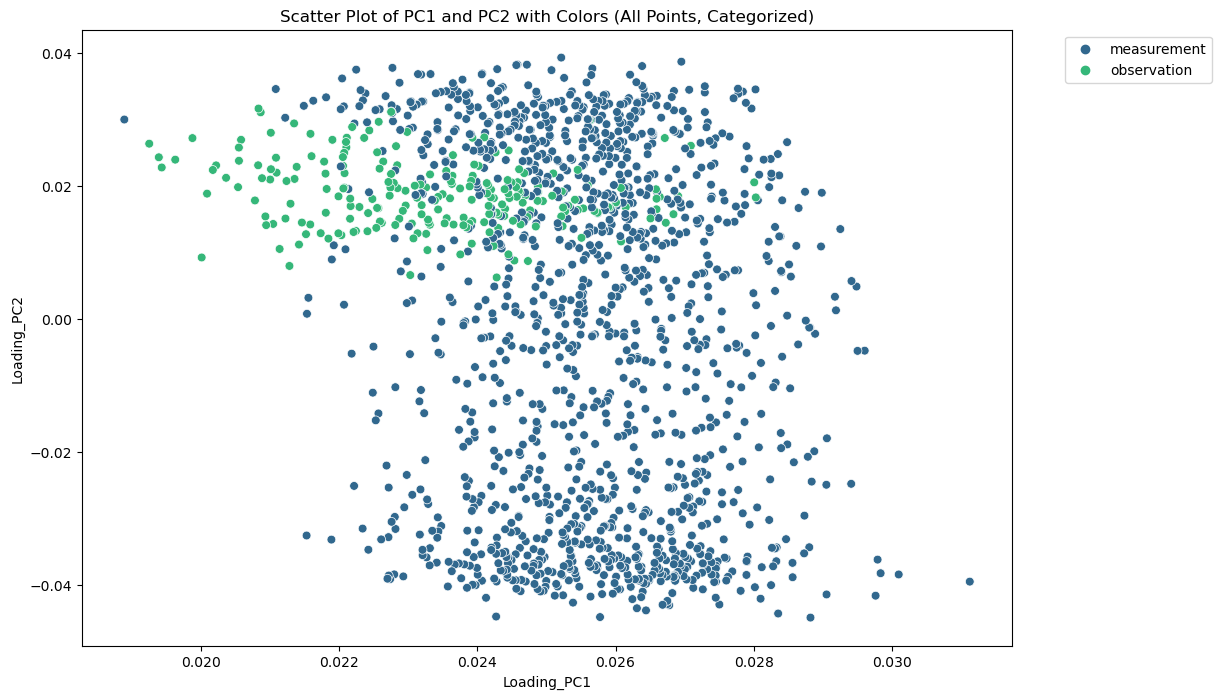

In [9]:
# Kategooriad
loadings['Category'] = loadings['Feature'].apply(lambda x: x.split('_')[0])

# Scatter plot loadingutest
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=loadings['Loading_PC1'], y=loadings['Loading_PC2'], hue=loadings['Category'], palette='viridis', s=40)

plt.title('Scatter Plot of PC1 and PC2 with Colors (All Points, Categorized)')
plt.xlabel('Loading_PC1')
plt.ylabel('Loading_PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()


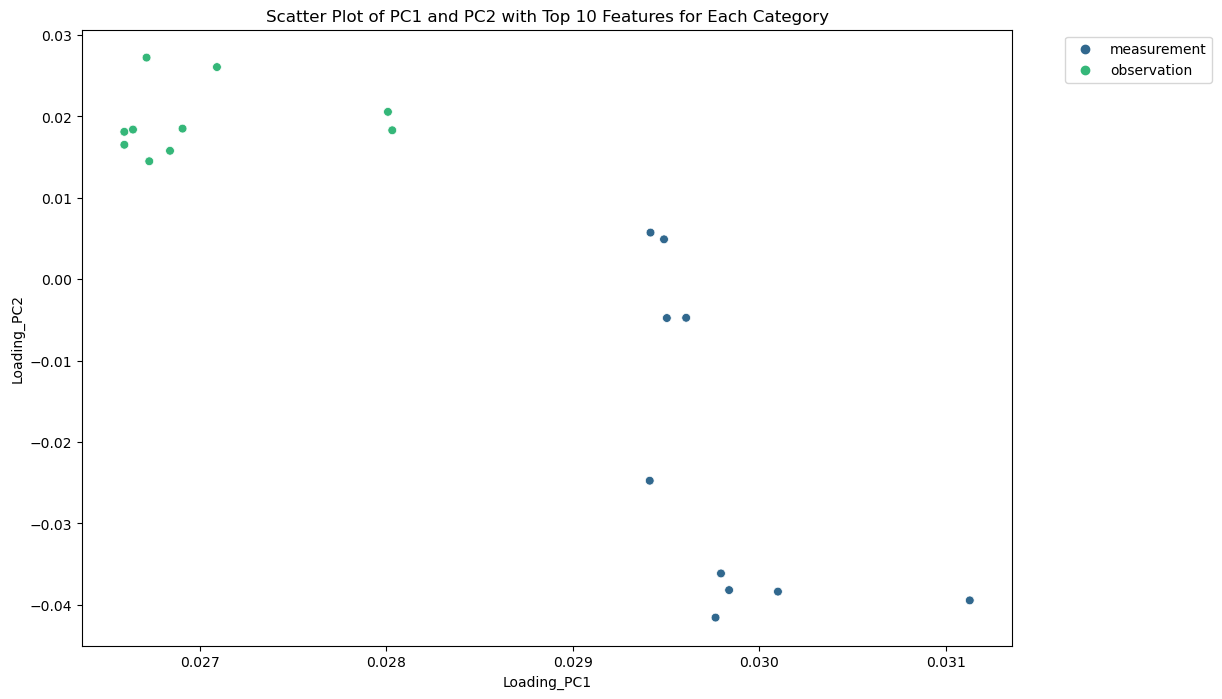

In [10]:
loadings['Category'] = loadings['Feature'].apply(lambda x: x.split('_')[0])

# Iga kategooria top 15 tunnust
top_features_by_category = loadings.groupby('Category').apply(lambda x: x.nlargest(10, 'Loading_PC1')).reset_index(drop=True)

# Scatter plot top 10
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=top_features_by_category['Loading_PC1'], y=top_features_by_category['Loading_PC2'],
                          hue=top_features_by_category['Category'], palette='viridis', s=40)

plt.title('Scatter Plot of PC1 and PC2 with Top 10 Features for Each Category')
plt.xlabel('Loading_PC1')
plt.ylabel('Loading_PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

# Top tunnuste dataframe
top_features_df = top_features_by_category[['Category', 'Feature', 'Loading_PC1', 'Loading_PC2']].copy()
top_features_df.columns = ['Category', 'Top_Feature', 'PC1_Value', 'PC2_Value']

# Features sorted by PC1 values

In [11]:
pd.set_option('display.max_rows', 50)

top_features_df = top_features_df.sort_values(by='PC1_Value', ascending=False)
top_features_df

,Category,Top_Feature,PC1_Value,PC2_Value
0,measurement,measurement_637,0.031129625,-0.039471246
1,measurement,measurement_422,0.030100560,-0.038393782
2,measurement,measurement_1076,0.029838645,-0.038207399
3,measurement,measurement_1221,0.029794903,-0.036160420
4,measurement,measurement_1027,0.029765831,-0.041583972
5,measurement,measurement_249,0.029608182,-0.004748591
6,measurement,measurement_720,0.029504519,-0.004779061
7,measurement,measurement_755,0.029489420,0.004891817
8,measurement,measurement_111,0.029416930,0.005721452
9,measurement,measurement_618,0.029412765,-0.024766315


## Features sorted by PC1 & PC2 values

In [12]:
top_features_df['Sum_PC1_PC2'] = top_features_df['PC1_Value'] + top_features_df['PC2_Value']
top_features_df_sorted = top_features_df.sort_values(by='Sum_PC1_PC2', ascending=False)
top_features_df_sorted = top_features_df_sorted.drop(columns=['Sum_PC1_PC2'])
top_features_df_sorted

,Category,Top_Feature,PC1_Value,PC2_Value
16,observation,observation_98,0.026713474,0.027222792
12,observation,observation_138,0.027091020,0.026056780
11,observation,observation_224,0.028008371,0.020555178
10,observation,observation_204,0.028031520,0.018290236
13,observation,observation_215,0.026906568,0.018496156
17,observation,observation_143,0.026640617,0.018377839
19,observation,observation_30,0.026594157,0.018102177
18,observation,observation_38,0.026594337,0.016510422
14,observation,observation_63,0.026839295,0.015770419
15,observation,observation_51,0.026727986,0.014484295


## Correlation matrix

In [13]:
file                 
data = load_data(file)
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['death'].abs().sort_values(ascending=False)
correlation_with_target.to_csv('correlation_results.csv', header=True)
correlations = pd.read_csv("correlation_results.csv")
correlations

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


,DEFINITION_ID,death
0,death,1.000000000
1,measurement_258,0.308030540
2,measurement_601,0.307923418
3,measurement_817,0.305947948
4,measurement_1325,0.305563490
...,...,...
4859,condition_434,0.000990781
4860,condition_1834,0.000695917
4861,condition_1885,0.000188921
4862,condition_1685,0.000032025


## Mutual information
**Mutual information measures the dependence between two random variables<br>Helps to Identify which features are more informative for predicting the target variable in a classification problem. Higher mutual information scores imply a stronger relationship between a feature and the target.**

In [14]:
data = load_data(file)
X = data.drop(columns=['death'])
y = data['death']

mutual_info = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame with feature names and their mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})

# Sort features by mutual information scores (descending order)
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

print(mi_df.head(10))

mi_df.to_csv('mutual_information_results.csv', index=False)
mutual_information = pd.read_csv("mutual_information_results.csv")
mutual_information # Siin peaks teil mutual_information df avanema kui kõik töötas nii nagu pidi

/tmp/ipykernel_91482/1291404932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/1291404932.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               Feature  Mutual_Information
3321   measurement_253         0.093111552
3630   measurement_531         0.087619122
2233      condition_85         0.084881476
3180  measurement_1325         0.084746859
3969   measurement_837         0.084734446
3400   measurement_324         0.083805647
3862   measurement_740         0.083264896
3253   measurement_192         0.082363027
3620   measurement_522         0.080798087
4092   measurement_948         0.080770247


,Feature,Mutual_Information
0,measurement_253,0.093111552
1,measurement_531,0.087619122
2,condition_85,0.084881476
3,measurement_1325,0.084746859
4,measurement_837,0.084734446
...,...,...
4858,condition_2365,0.000000000
4859,condition_2367,0.000000000
4860,condition_2369,0.000000000
4861,condition_237,0.000000000


# SMOTE usage

**SMOTE kasutamises ei ole me kindlad, kas seda on õige kasutada reaalsete andmete peal, aga treening ja valideerimise andmetel läheb auc-roc skoor kõvasti paremaks<br>Sellegipoolest ei ole me kindlad, et kas seda on mõistlik terviseandmete peal kasutada seega see on hetkel pigem lihtsalt siia kerge lisa ja kui leiate, et SMOTE kasutamine oleks okei siis integreeriksime selle oma töövoogu sisse**

In [15]:
# Function to load data
def load_data(file):
    data = pd.read_csv(file)
    surnud = data[data["DEFINITION_ID"] == "death"]
    subject_ids = surnud["SUBJECT_ID"]
    surnud = data[data["SUBJECT_ID"].isin(subject_ids)]
    surnud["TIME"] = 1
    elus = data[data["DEFINITION_ID"] != "death"]
    elus["TIME"] = 1
    elus_filtered = elus[~elus["SUBJECT_ID"].isin(surnud["SUBJECT_ID"])]
    combined_data = pd.concat([surnud, elus_filtered])
    combined_data.sort_values(by='SUBJECT_ID', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)
    pivot_combined_data = combined_data.pivot_table(index='SUBJECT_ID', columns='DEFINITION_ID', values='TIME', aggfunc='sum', fill_value=0)
    
    return pivot_combined_data

# Function to identify important features
def identify_important_features(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    pc_columns = [f'PC_{i+1}' for i in range(n_components)]
    explained_variance_ratio = pca.explained_variance_ratio_
    loadings_pc1 = pca.components_[0]
    loading_df = pd.DataFrame({'Feature': X.columns, 'Loading_PC1': loadings_pc1})
    loading_df['Absolute_Loading_PC1'] = loading_df['Loading_PC1'].abs()
    loading_df = loading_df.sort_values(by='Absolute_Loading_PC1', ascending=False)
    print(f'Explained Variance Ratio - PC1: {explained_variance_ratio[0]:.4f}')
    print(f'Explained Variance Ratio - PC2: {explained_variance_ratio[1]:.4f}')
    print(f'Explained Variance Ratio - PC3: {explained_variance_ratio[2]:.4f}')
    print(f'Explained Variance Ratio - PC4: {explained_variance_ratio[3]:.4f}')
    return pd.DataFrame(X_pca, columns=pc_columns), explained_variance_ratio, pca, loading_df

# Function to train a model
def train_model(X, y, model_type):
    svm_params = {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 100}
    knn_params = {'weights': 'distance', 'p': 2, 'n_neighbors': 16, 'algorithm': 'auto'}
    
    if model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'SVM':
        model = SVC(probability=True, random_state=42,**svm_params)
    elif model_type == 'KNeighbors':
        model = KNeighborsClassifier(**knn_params)
    else:
        raise ValueError(f'Invalid model type: {model_type}')
    
    model.fit(X, y)
    return model

# Function to evaluate the model
def evaluate_model(model, X, y):
    y_probabilities = model.predict_proba(X)[:, 1]
    auc_roc = roc_auc_score(y, y_probabilities)
    return auc_roc

# Function to perform the entire workflow
def main(file):
    data = load_data(file)
    X = data.drop(columns=['death'])
    y = data['death']
    
    important_features, explained_variance_ratio, pca, loading_df = identify_important_features(X, n_components=25)
     
    # SMOTE kasutatakse peale PCA-d
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(important_features, y)
    
    # Resmapled df
    resampled_data = pd.DataFrame(X_resampled, columns=important_features.columns)
    resampled_data['death'] = y_resampled
    
    model_types = ['RandomForest','SVM', 'KNeighbors']
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(resampled_data.drop(columns=['death']), resampled_data['death'], test_size=0.2, random_state=42)

    for model_type in model_types:
        model = train_model(X_train, y_train, model_type=model_type)
        auc_roc = evaluate_model(model, X_test, y_test)
        results[model_type] = auc_roc
        print(f'{model_type} AUC-ROC: {auc_roc}')

    return results, loading_df

# LISAGE SIIA OMA FAIL
#file_path = "synthetic_data_lung_cancer.csv"

# Run the main script
results,loading_df = main(file)
print("\nAUC-ROC Scores:")
for model_type, auc_roc in results.items():
    print(f'{model_type}: {auc_roc}')

/tmp/ipykernel_91482/871157962.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
/tmp/ipykernel_91482/871157962.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


Explained Variance Ratio - PC1: 0.2754
Explained Variance Ratio - PC2: 0.0501
Explained Variance Ratio - PC3: 0.0374
Explained Variance Ratio - PC4: 0.0312


NameError: name 'SMOTE' is not defined